In [256]:
import copy
# ------------------------------
import pandas as pd
import numpy as np
import scipy.stats as st
# ------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve
# ------------------------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

# Описание выбранного набора данных и решаемая задача

**Тема курсовой работы**: Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения.

**Задача**: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи необходимо определить решаемую задачу машщинного обучения и данные её характеризующие.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "одобрить кредит" или "не одобрить кредит" по некторому набору признаков. Набор данных взять с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), ниже приведено подробное описание набора данных.

Набор данных представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30-59DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому в дальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.
 
В качетсве оценки эффектинвостей работы моделей выбраны метрики **precision** и **roc auc**:
- **precision** (точность) выбран по той причине, что банку выгодно одобрять кредиты только тем кто в состоянии его выплатить, в противном случае он несёт убытки.
- **roc auc** (площадь под кривой ROC) выбрана так как показывает насколько хорошо модель различает положительные (одобрение кредита) и отрицательные (отказ в кредитовании) метки классов. 

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [257]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Визуализация данных

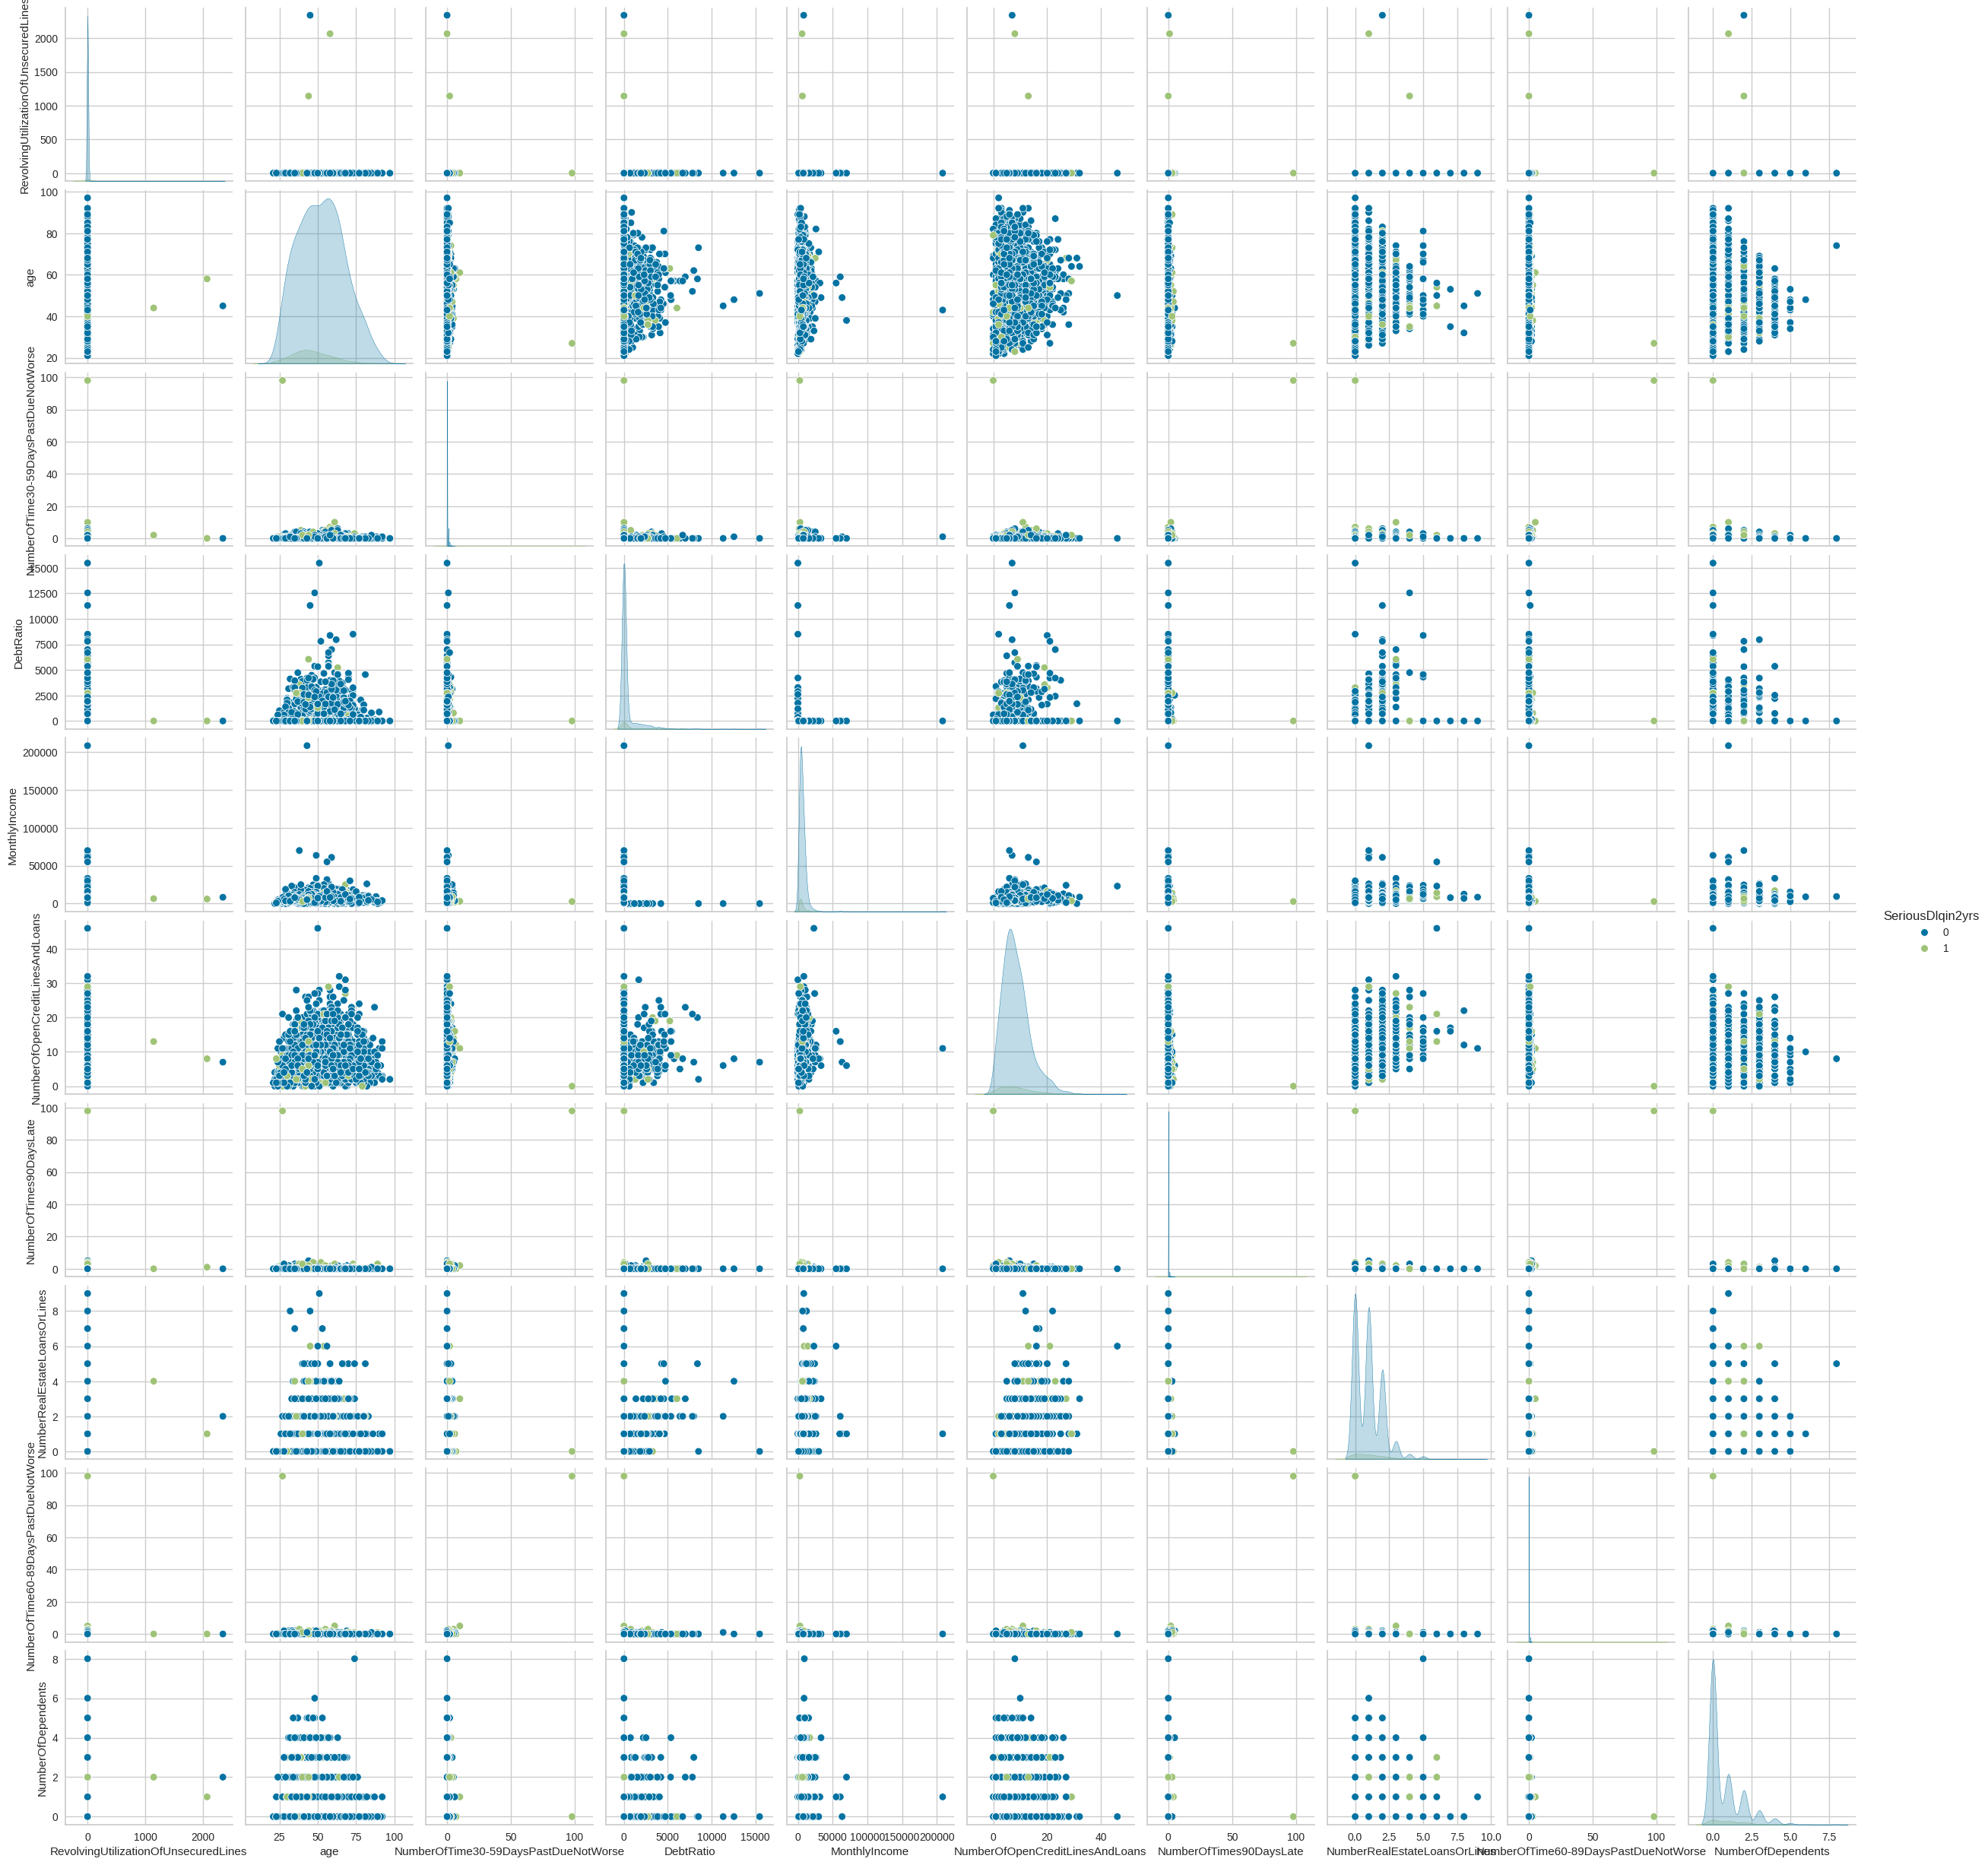

In [258]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

# Описательный анализ данных 

## Решение проблемы пропусков в наборе данных

### Визуализация пропусков

Для визуализации используется библиотека missingno

<Axes: >

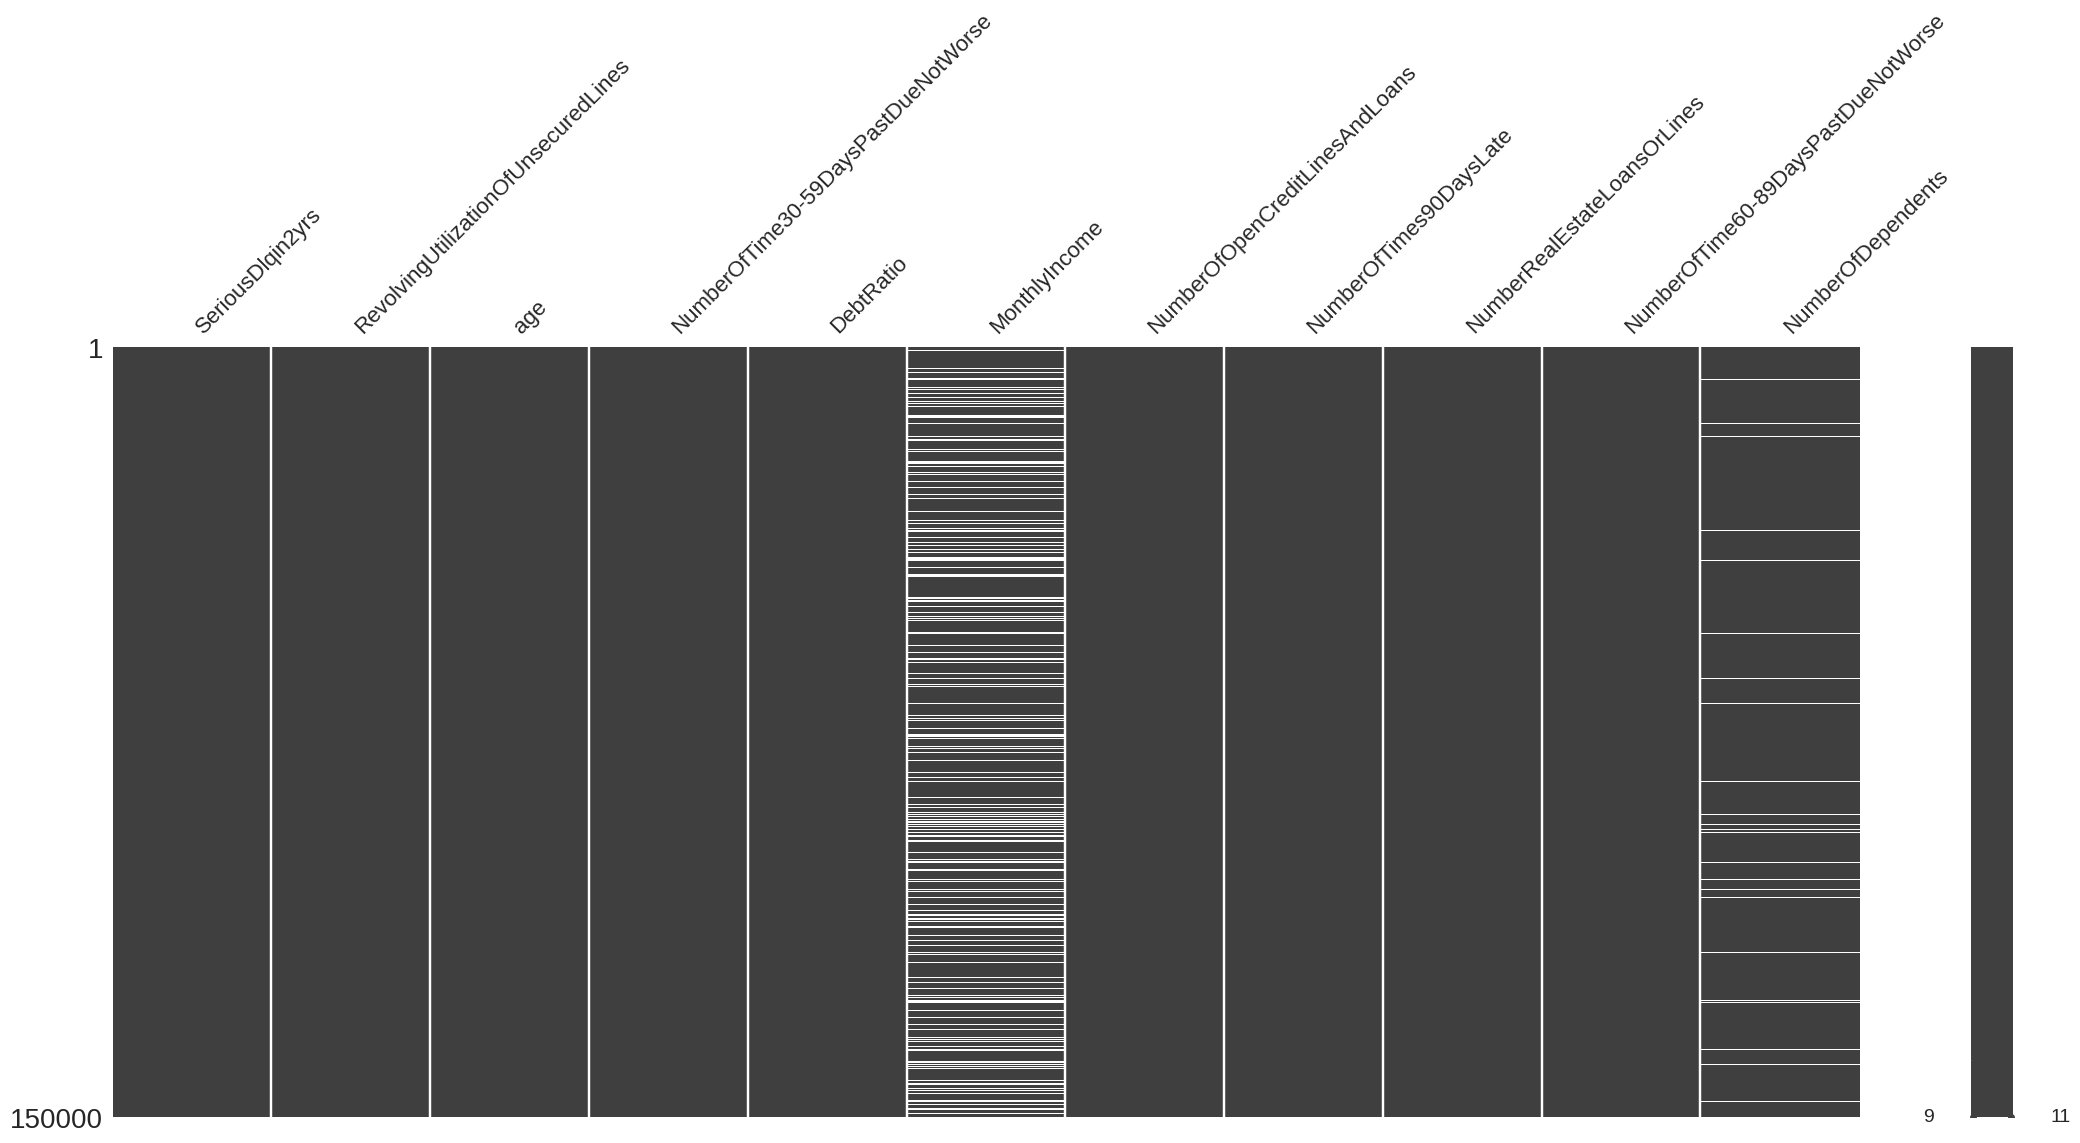

In [259]:
import missingno as msno
msno.matrix(data)

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки. 

Поэтому пропущенные значения будут восстанавливаться:
- Для **MonthlyIncome**, пропуски в котором составляют примерно 19% от всех данных, будет построен регрессор на основе всеех остальных атрибутов.
- Для **NumberOfDependents**, пропуски в котором составляют примерно 2% от всех данных, значения будут восстановлены медианным значением.

### Восстановление данных в атрибуте NumberOfDependents

In [260]:
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(data["NumberOfDependents"].median())

### Восстановление данных в атрибуте MonthlyIncome

In [261]:
train = data[data["MonthlyIncome"].isnull() == False]
test = data[data["MonthlyIncome"].isnull() == True]

X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train["MonthlyIncome"]
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

lmMod = LinearRegression().fit(X_train, y_train)

pred = []
for _ in lmMod.predict(X_test):
    if _ > 0:
        pred.append(_)
    else:
        # Если зарплатала отлична от 0, то заменяю медианным значением
        pred.append(y_train.median())

j = 0
for i in test.index:
    data.loc[i, "MonthlyIncome"] = pred[j] 
    j += 1

<Axes: >

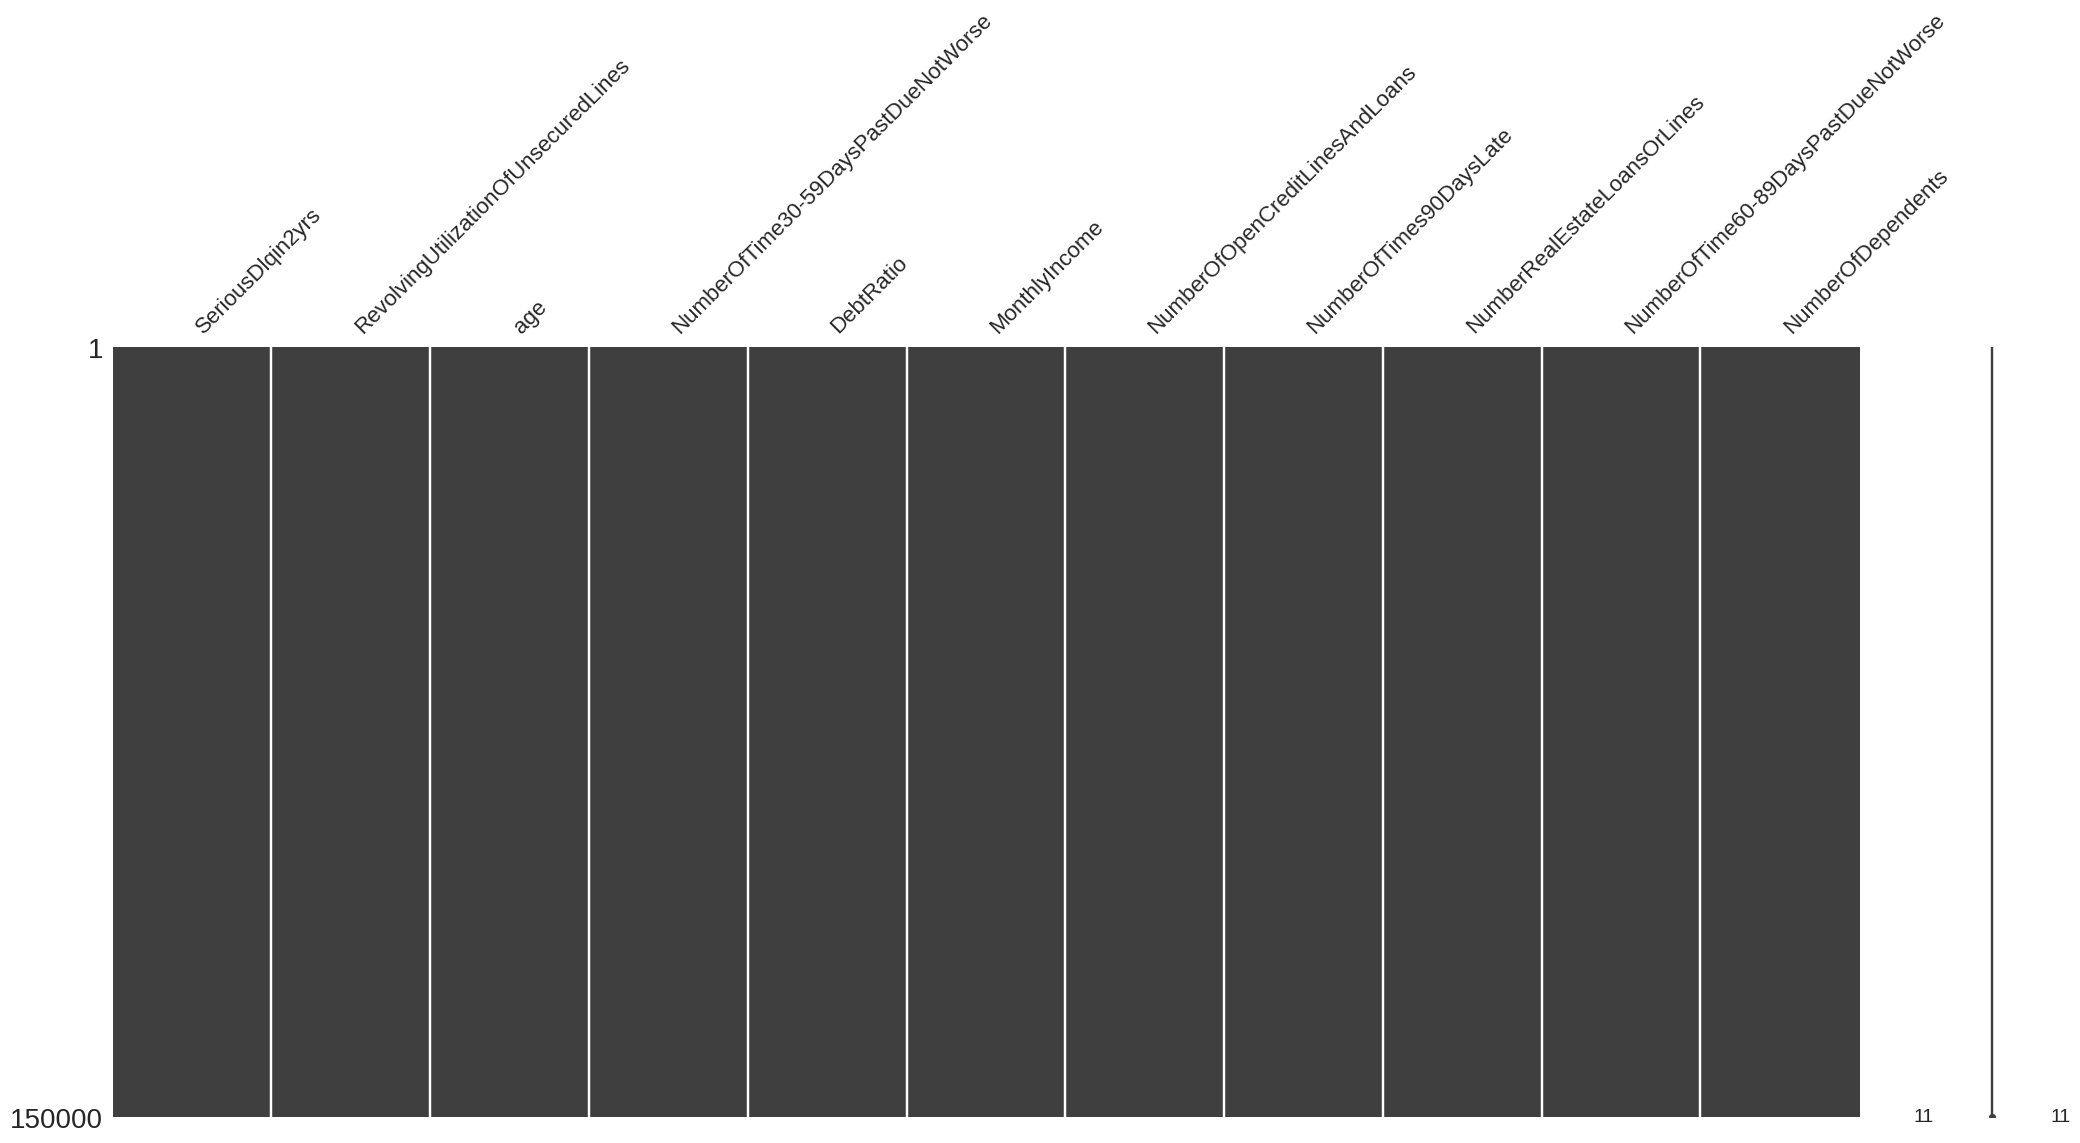

In [262]:
import missingno as msno
msno.matrix(data)

## Поиск и удаление выбросов

### Визуализация выбросов с помощбю "коробки с усами"

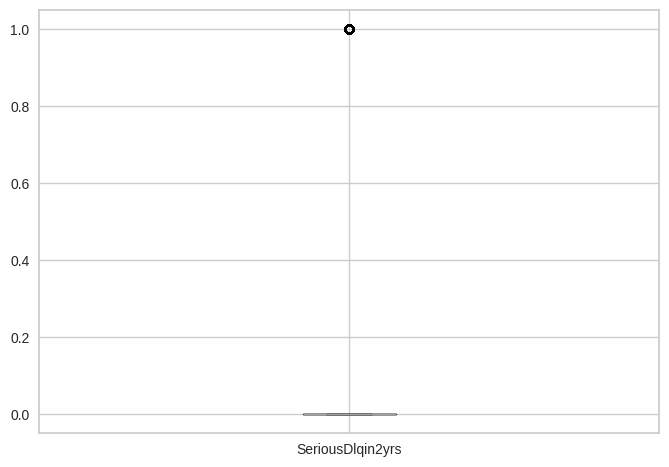

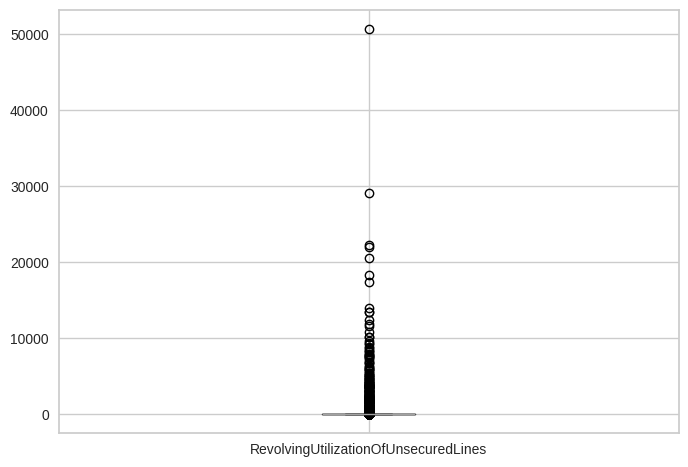

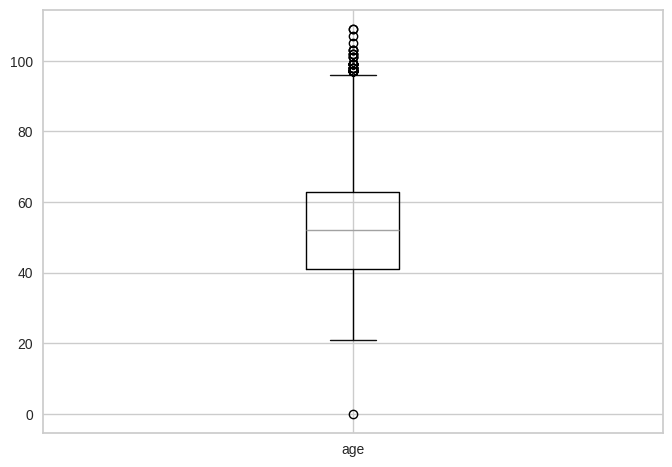

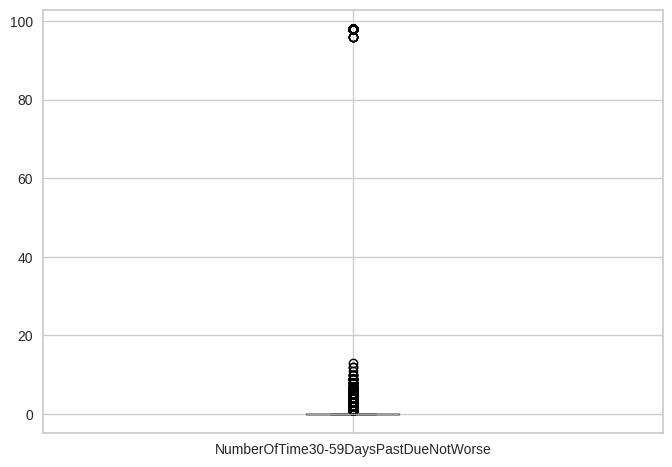

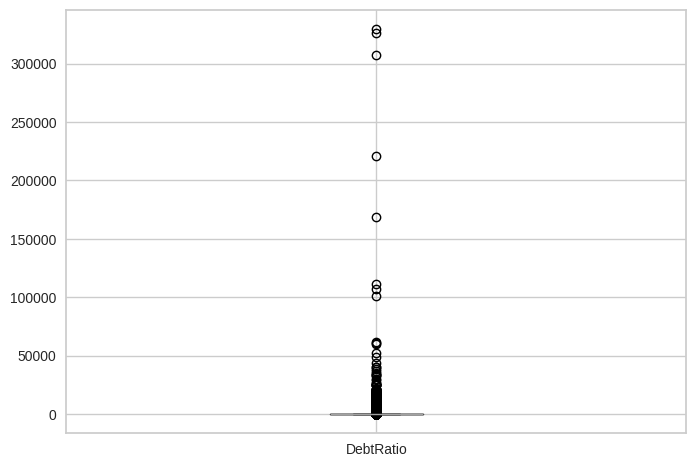

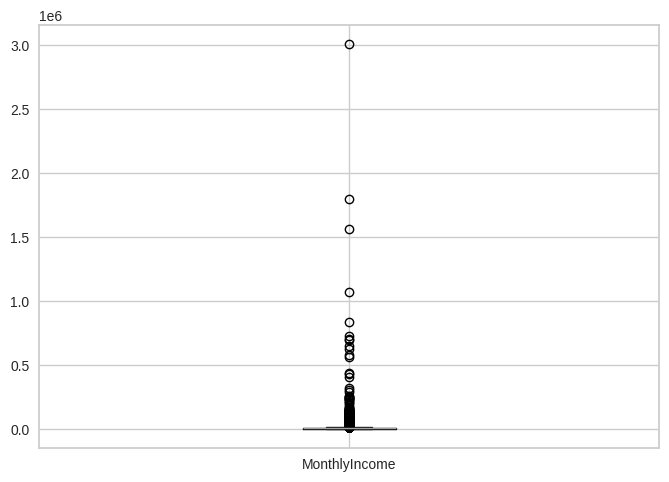

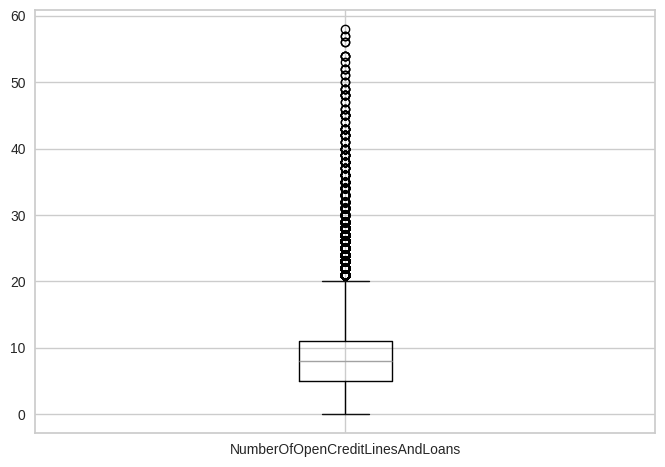

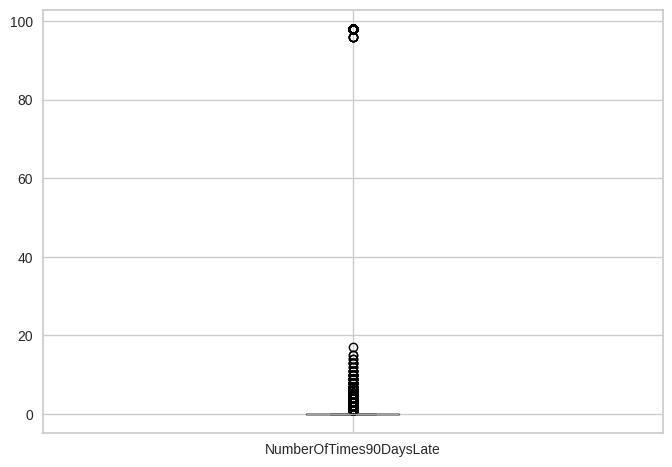

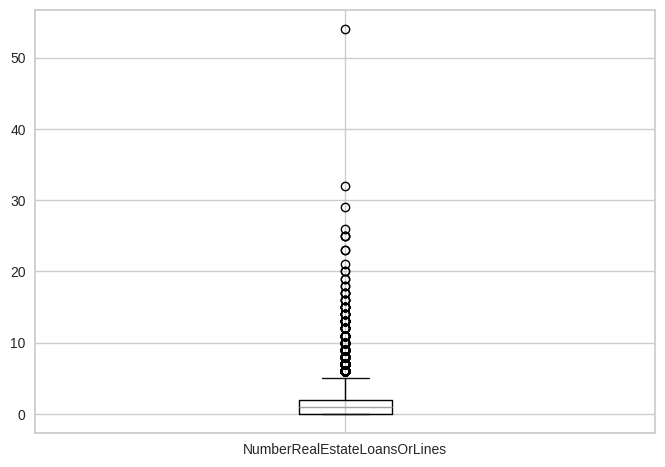

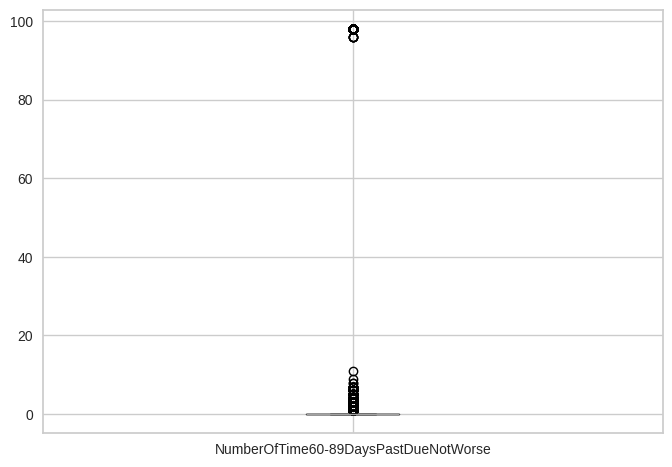

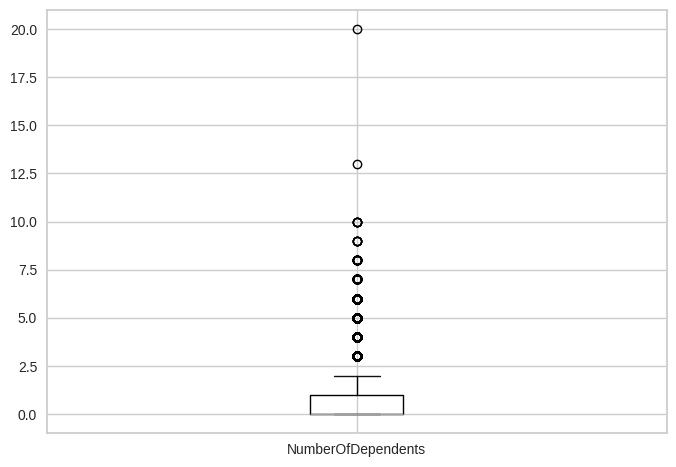

In [263]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Сначала будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 22 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 22 лет.

Другие заменяю на медиану. Кроме NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, так как, в основном, они равны нулю и выбросы в этих признаках несут важную инфорацию. 

In [264]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 22
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

In [265]:
another_columns = set(data.columns) - set(["age", "SeriousDlqin2yrs", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"])
for column in another_columns:
    Q1, Q3 = data[column].quantile(0.25), data[column].quantile(0.75)
    IRQ = Q3 - Q1 
    topline = Q3 + IRQ * 1.5 
    downline = Q1 - IRQ * 1.5 
    median = data[column].interpolate()
    data.loc[data[data[column] > topline].index, column] = median
    data.loc[data[data[column] < downline].index, column] = median

## Визуализация распределения

Из-за огромного количества данных построить распределения для каждого атрибута по всем данным слишком затратно по времени. Поэтому использую train_test_split из sklearn для создания репрезентативной подвыборки. Обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

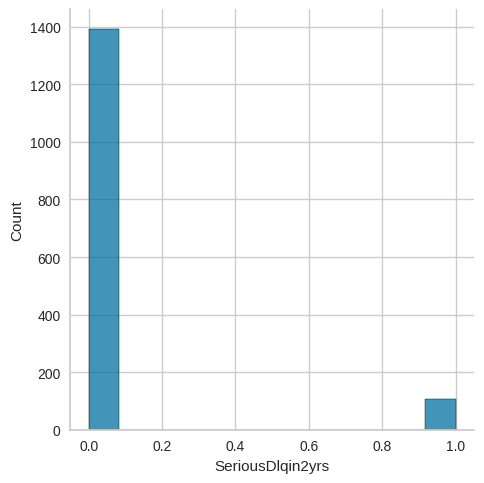

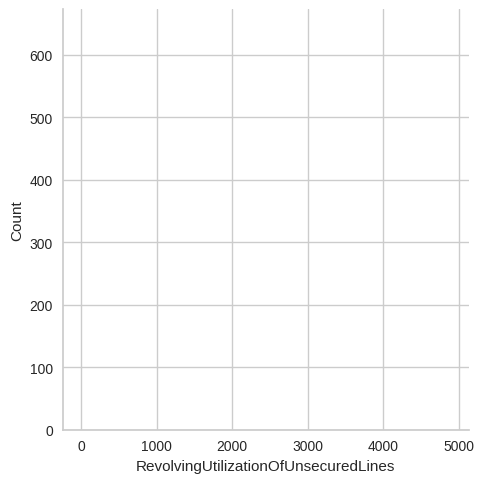

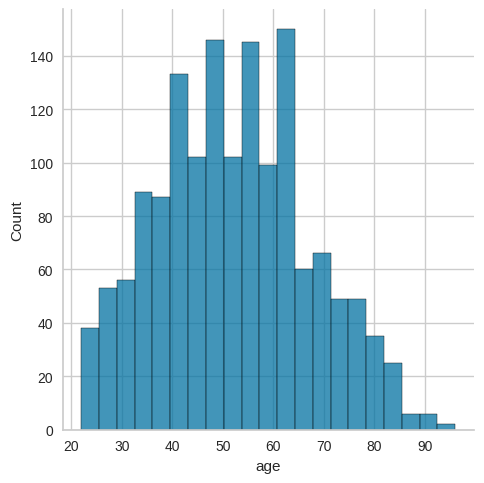

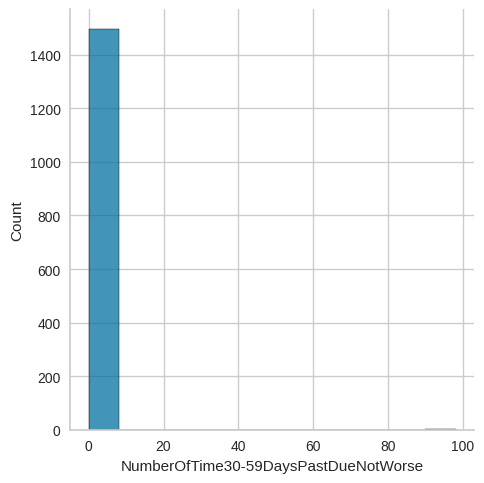

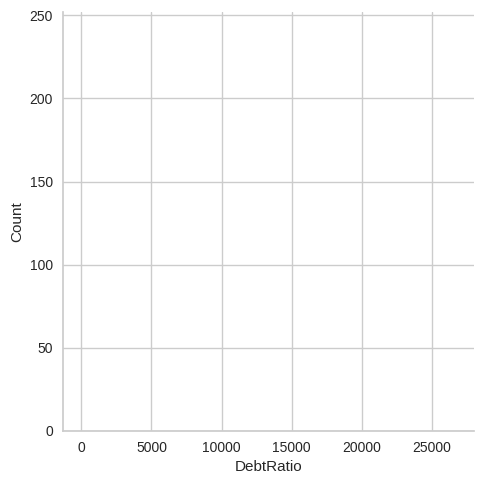

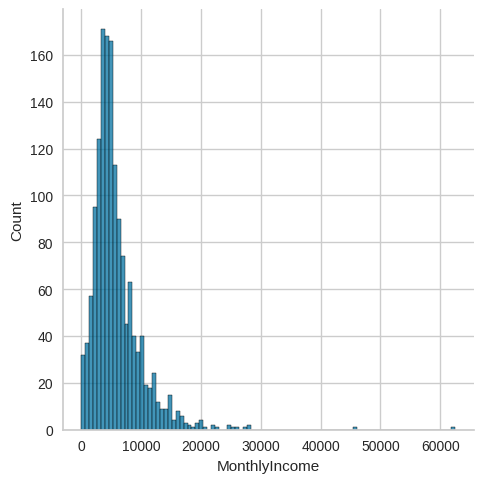

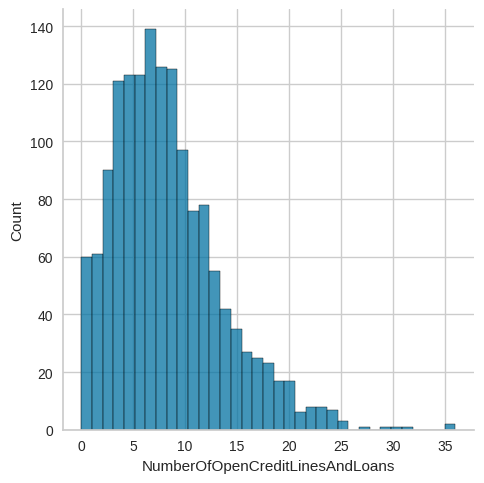

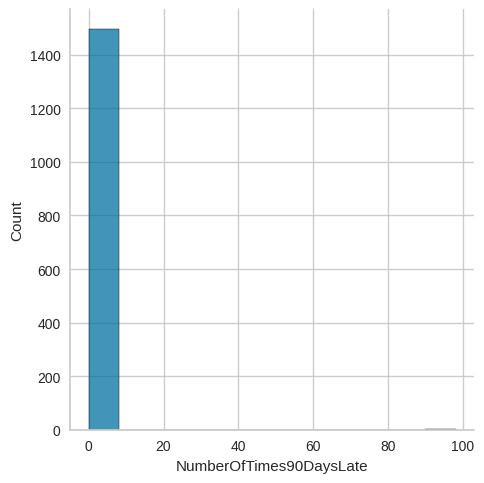

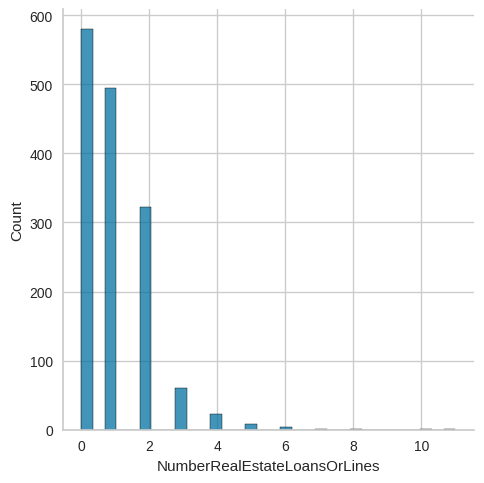

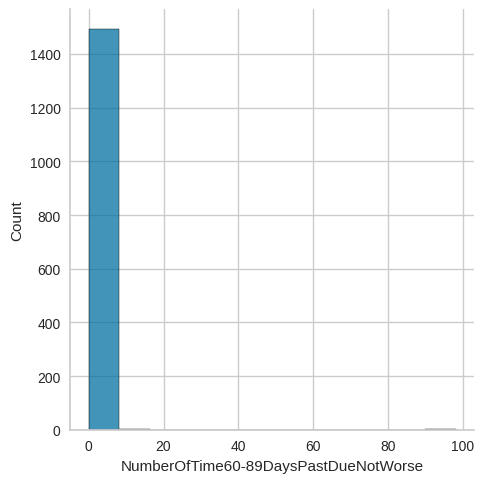

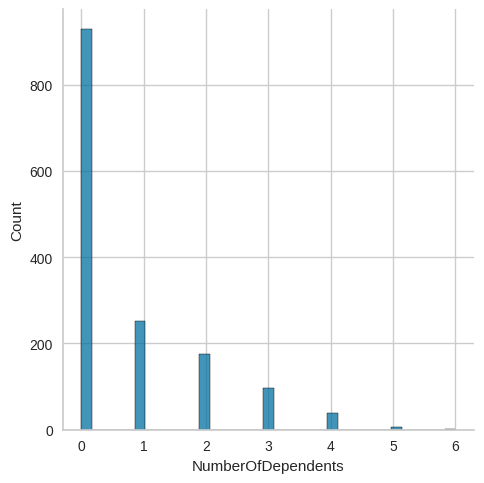

In [266]:
for column in data.columns:
    data_col, _ = train_test_split(data[column], test_size=0.01)
    display(sns.displot(_))

## Корреляционная матрица

In [267]:
def draw_cov(data):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix')
    sns.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

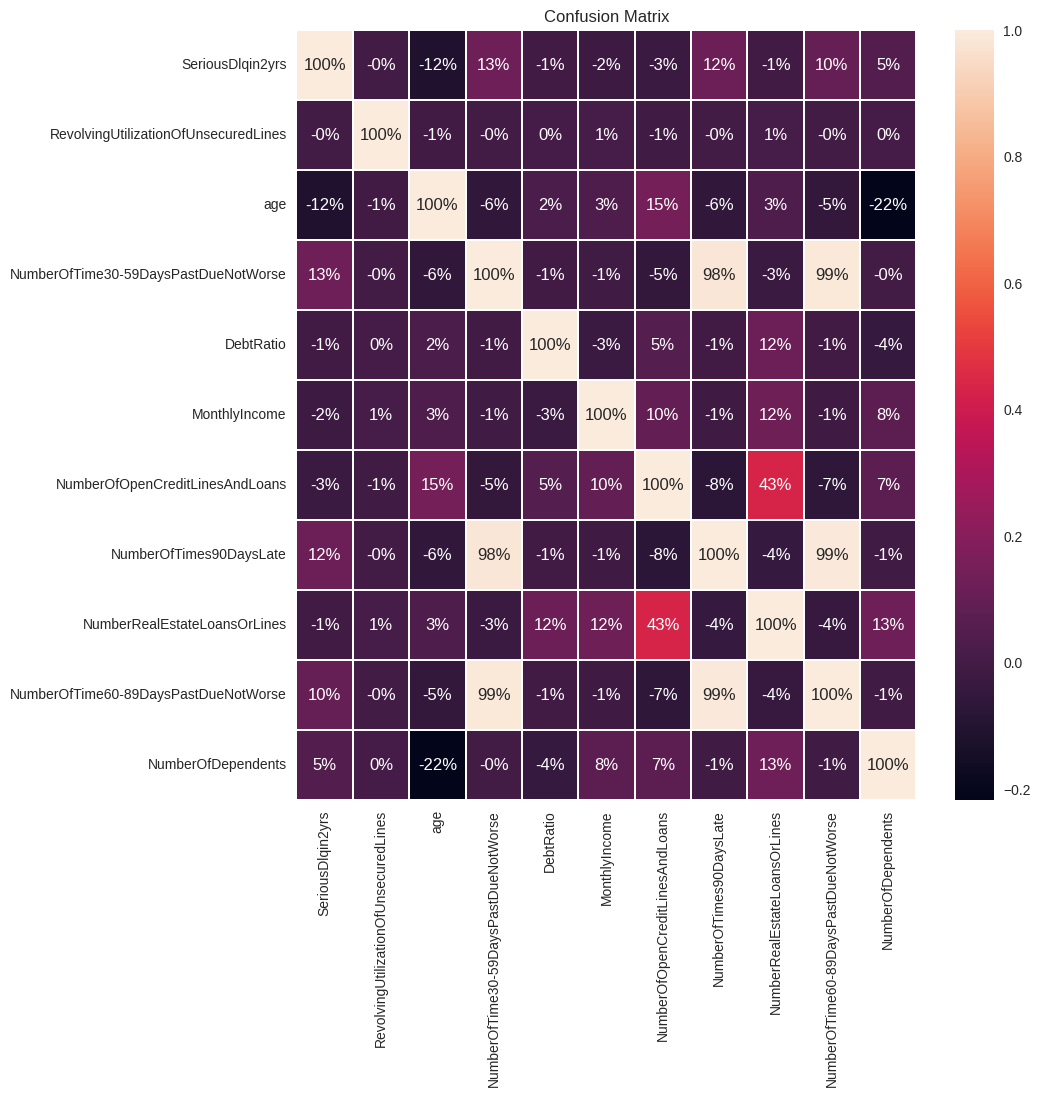

In [268]:
draw_cov(data)

# Выявим наиболее информативные атрибуты

Эта часть анализа выполнена с помощью случайного леса - обученный на всей выборке, модель покажет информативность и вариативность каждого отдельного атрибута. 

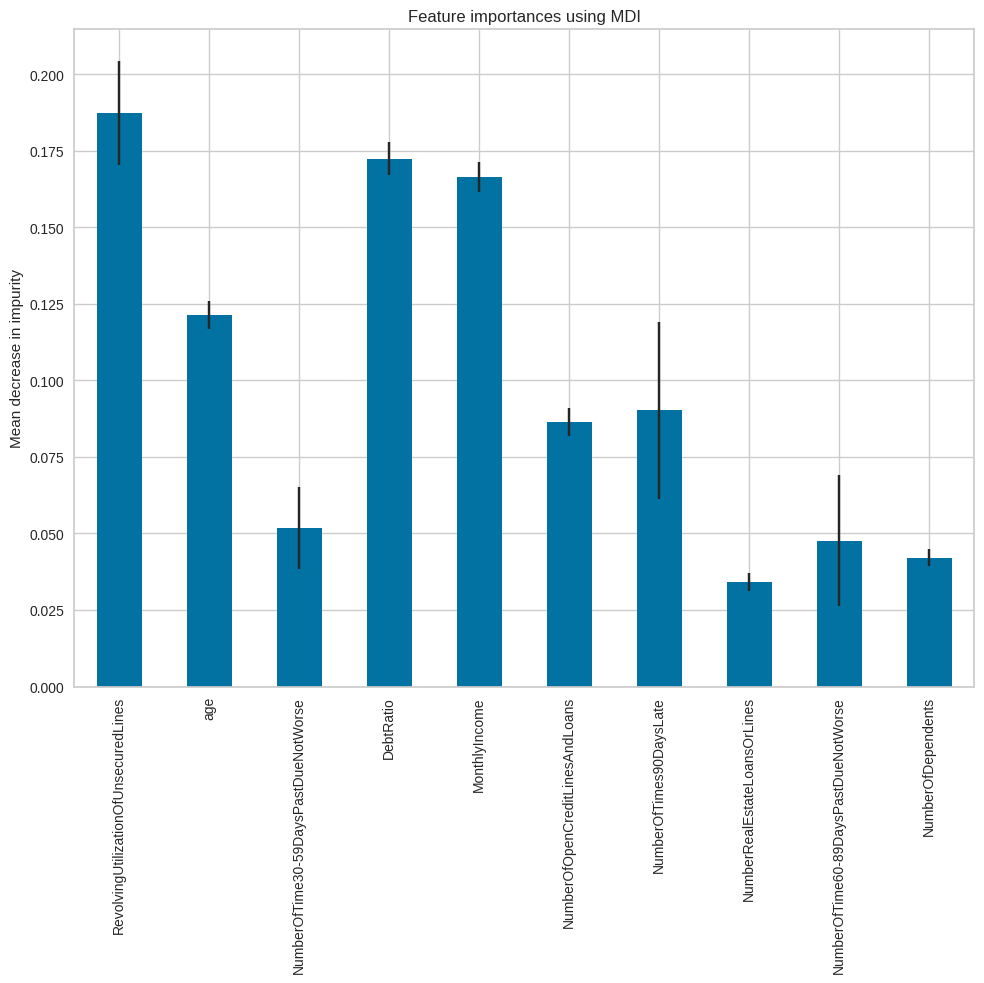

In [269]:
X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(0, 10, 1), labels=X.columns.tolist())
fig.tight_layout()

## Продолжение анализа важности атрибутов

Анализ атрибутов с помощью случайного леса ничего существенного не дал, поэтому решено применить PCA (метод главных компонент).

Как видно, 6 первых атрибутов PCA объясняют ~90% всей дисперсии данных! 

Общая объясненная дисперсия 0.9429654585256706


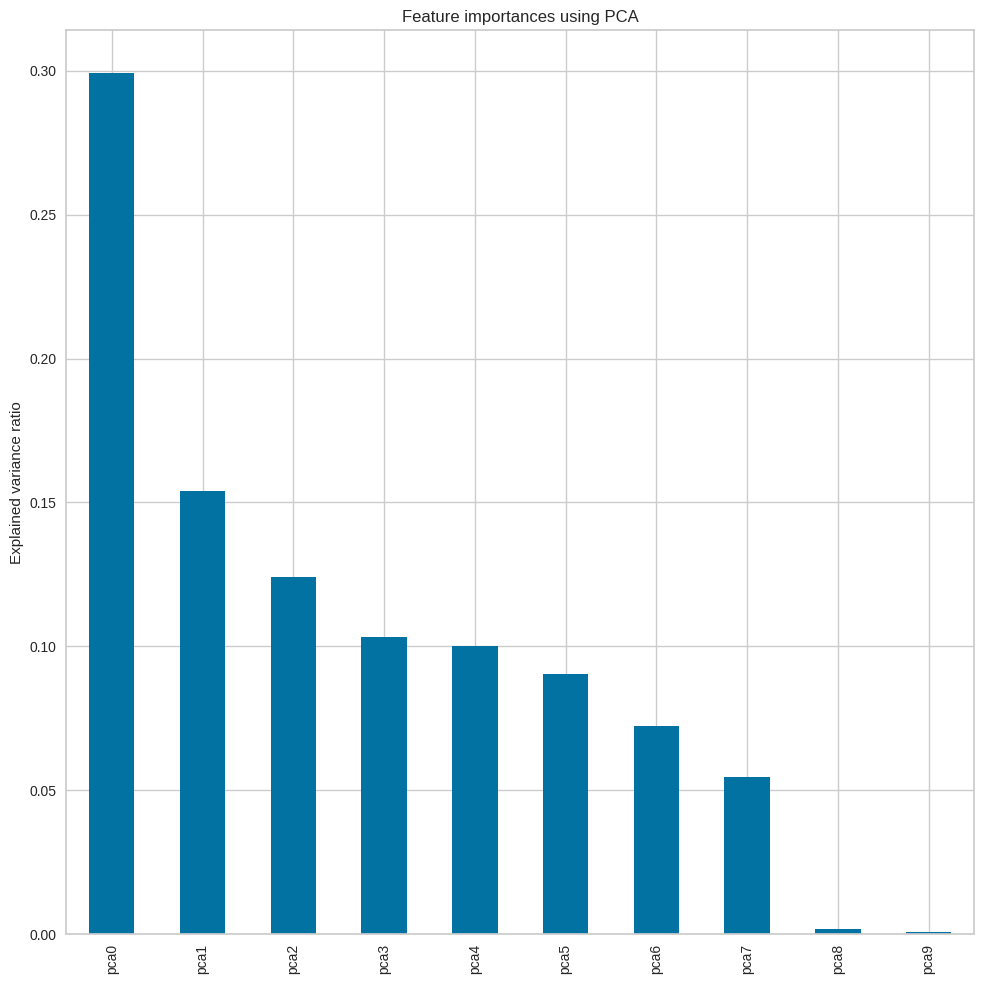

In [272]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

pca_machine = PCA(n_components=min(X.shape[0], X.shape[1]), svd_solver="covariance_eigh")

pca_X = pca_machine.fit(pd.DataFrame(scaled_X, columns=X.columns.values))

pca_importances = pd.Series(pca_X.explained_variance_ratio_, index=pca_X.get_feature_names_out())

fig, ax = plt.subplots(figsize=(10,10))
pca_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using PCA")
ax.set_ylabel("Explained variance ratio")
ax.set_xticks(np.arange(0, 10, 1), labels=pca_X.get_feature_names_out())
fig.tight_layout()

most_explainde_pca_X = pca_X.explained_variance_ratio_[:7]
print(f"Общая объясненная дисперсия {most_explainde_pca_X.sum()}")

transformed_X = pca_machine.transform(pd.DataFrame(scaled_X, columns=X.columns.values))

# Разделение данных на тестовую и обучающую выборки

Из-за огромного количества данных для теста достаточно 0.01 от всего массива данных

In [ ]:
X, y = transformed_X, data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  

# Подбор моделей

## DecisionTreeClassifier

In [ ]:
model_DT = DecisionTreeClassifier().fit(X_train, y_train)
print(f"ROC_AUC: {roc_auc_score(y_test, model_DT.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y, scoring="roc_auc"))}")

ROC_AUC: 0.6009062683660649
 Cross validation score: 0.5974543809302142


## GaussianNB

In [16]:
from sklearn.naive_bayes import GaussianNB

pipline = make_pipeline(GaussianNB())
model_GNB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GNB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.652112574002958
 Cross validation score: 0.8001764693865621


## LogisticRegression

In [17]:
from sklearn.linear_model import LogisticRegression 

pipline = make_pipeline(LogisticRegression())
model_LogReg = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5198694479134256
 Cross validation score: 0.698182828196951


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

pipline = make_pipeline(RandomForestClassifier())
model_RF = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_RF.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5856422777164491
 Cross validation score: 0.8005831022867959


## Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

pipline = make_pipeline(GradientBoostingClassifier())
model_GB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5751239243198548
 Cross validation score: 0.8306611434401455


## KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

pipline = make_pipeline(KNeighborsClassifier())
model_KNN = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_KNN.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5585006376768766
 Cross validation score: 0.6895158695031907


## Neural Network

In [21]:
from sklearn.neural_network import MLPClassifier

pipline = make_pipeline(MLPClassifier())
model_MLP = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_MLP.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5784260865488302
 Cross validation score: 0.8349540224575884


## AdaBoosting

In [22]:
from sklearn.ensemble import AdaBoostClassifier

pipline = make_pipeline(AdaBoostClassifier())
model_Ada = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_Ada.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5518806850444528
 Cross validation score: 0.8197848845034912


## Подбор гиперпараметров

Для kaggle настройка с помощью optuna - умная версия random search. Оцениваю по roc_auc, так как нужно получить корректные вероятности классов. 

## Настройка гиперпараметров Logistic Regression с помощью байесовсокой оптимизации

In [23]:
from bayes_opt_class import BayesOptimization

params = {'C': (float, [0.1, 10]),
          "intercept_scaling": (float, [0.1, 10]),
          "max_iter": (int, [100, 1000]),
          "tol": (float, [1e-10, 0.99])}
score, params = BayesOptimization(model_LogReg["logisticregression"], params, n_iters=100, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9333983223171096
best params: {'C': np.float64(2.6176250082149863), 'intercept_scaling': np.float64(5.372913016671583), 'max_iter': np.float64(848.0), 'tol': np.float64(0.34268535096091063)}


### Посмотрим на результат

In [24]:
from sklearn.linear_model import LogisticRegression 

params = {'C': np.float64(1.4603291535529197), 
          'intercept_scaling': np.float64(6.1403562236406435), 
          'max_iter': np.int64(835.0), 
          'tol': np.float64(0.29676526487681176)}

pipline = make_pipeline(LogisticRegression(**params))
model_LogReg = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.506303482099347
 Cross validation score: 0.715745613929832


### Анализ модели

Ниже представлен график обучения модели

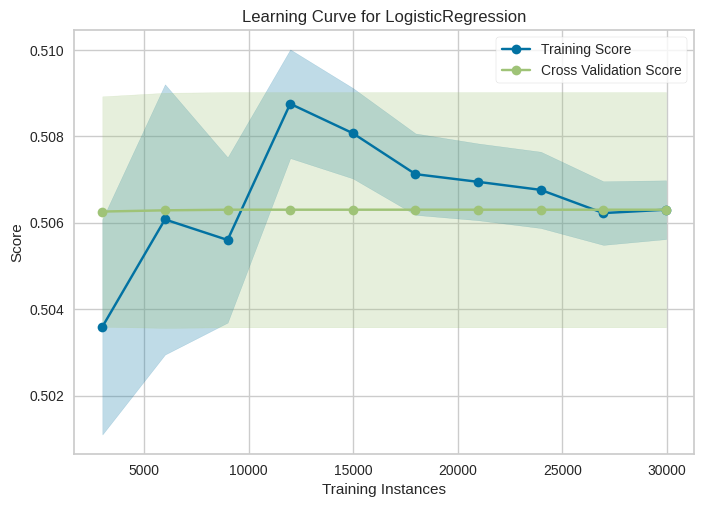

In [25]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    model_LogReg, scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Настройка гиперпараметров Gradient Boosting с помощью байесовсокой оптимизации

In [26]:
from bayes_opt_class import BayesOptimization

params = {"max_depth": (int, [2, 100]), 
          "min_samples_leaf": (int, [2, 100]),
          "min_samples_split": (int, [2, 100]), 
          "n_estimators": (int, [2, 100]),
          "ccp_alpha": (float, [1e-10, 1]),
          "learning_rate": (float, [1e-10, 1]),
          "max_features": (int, [1, 6]),
          "max_leaf_nodes": (int, [2, 100]),
          "min_impurity_decrease": (int, [1e-10, 1]),
          "tol": (int, [1e-10, 1])
}   

score, params = BayesOptimization(model_GB["gradientboostingclassifier"], params, n_iters=10, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9331646313252568
best params: {'max_depth': np.float64(41.0), 'min_samples_leaf': np.float64(22.0), 'min_samples_split': np.float64(23.0), 'n_estimators': np.float64(25.0), 'ccp_alpha': np.float64(0.6582128026095139), 'learning_rate': np.float64(0.34769567524460415), 'max_features': np.float64(4.0), 'max_leaf_nodes': np.float64(4.0), 'min_impurity_decrease': np.float64(0.0), 'tol': np.float64(0.0)}


### Посмотрим на результат

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': np.int64(8.0), 
          'min_samples_leaf': np.int64(16.0), 
          'min_samples_split': np.int64(34.0), 
          'n_estimators': np.int64(63.0), 
          'max_features': np.int64(3.0), 
          'max_leaf_nodes': np.int64(31.0)}

pipline = make_pipeline(GradientBoostingClassifier(**params))
model_GB = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5800070184710815
 Cross validation score: 0.8323481610588981


### Анализ модели

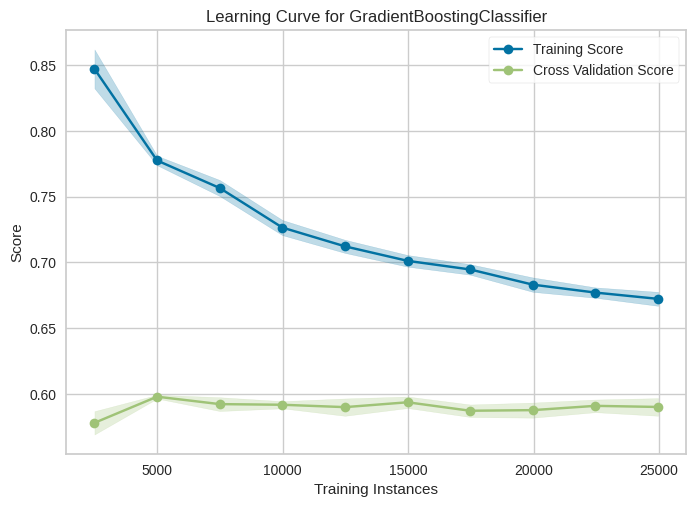

In [28]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    model_GB, scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Настройка гиперпараметров Ada Boosting с помощью optuna

In [ ]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective(trial, X, y):
    # Определяем пространство параметров для оптимизации
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', 1, 10),
        'base_estimator__min_samples_split': trial.suggest_int('base_estimator__min_samples_split', 2, 20),
        'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', 1, 10),
    }
    
    # Создаем базовый классификатор (дерево решений)
    base_estimator = DecisionTreeClassifier(
        max_depth=params['base_estimator__max_depth'],
        min_samples_split=params['base_estimator__min_samples_split'],
        min_samples_leaf=params['base_estimator__min_samples_leaf']
    )
    
    # Создаем AdaBoost с текущими параметрами
    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    # Используем кросс-валидацию для оценки качества
    scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Возвращаем средний ROC-AUC по фолдам
    return scores.mean()

# Оптимизация с Optuna
def optimize_adaboost(X, y, n_trials=100):
    # Создаем study и запускаем оптимизацию
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    # Выводим лучшие параметры
    print("Best trial:")
    trial = study.best_trial
    print(f"  ROC-AUC: {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study.best_params

best_params = optimize_adaboost(X, y, n_trials=20)

[I 2025-04-07 14:24:07,688] A new study created in memory with name: no-name-49fc13b0-ca30-4998-8727-755a508ed0a4
[I 2025-04-07 14:26:05,209] Trial 0 finished with value: 0.8288229287802045 and parameters: {'n_estimators': 357, 'learning_rate': 0.22039530695742018, 'base_estimator__max_depth': 2, 'base_estimator__min_samples_split': 4, 'base_estimator__min_samples_leaf': 6}. Best is trial 0 with value: 0.8288229287802045.
[I 2025-04-07 14:37:18,850] Trial 1 finished with value: 0.8182069550700847 and parameters: {'n_estimators': 451, 'learning_rate': 0.11801866975712022, 'base_estimator__max_depth': 10, 'base_estimator__min_samples_split': 7, 'base_estimator__min_samples_leaf': 6}. Best is trial 0 with value: 0.8288229287802045.
[I 2025-04-07 14:42:55,943] Trial 2 finished with value: 0.8263303764396959 and parameters: {'n_estimators': 285, 'learning_rate': 0.11883466710685638, 'base_estimator__max_depth': 8, 'base_estimator__min_samples_split': 5, 'base_estimator__min_samples_leaf': 3

KeyboardInterrupt: 

### Посмотрим на результат

In [30]:
from sklearn.ensemble import AdaBoostClassifier

pipline = make_pipeline(AdaBoostClassifier())
model_Ada = pipline.fit(X_train, y_train)
print(f" ROC_AUC: {roc_auc_score(y_test, model_Ada.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5518806850444528
 Cross validation score: 0.8197848845034912


### Анализ модели

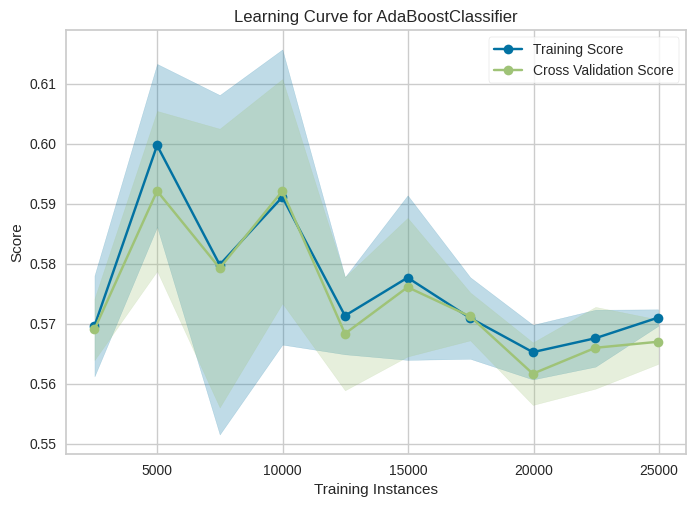

In [31]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    model_Ada, scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_test, y_test).show()

## Kaggle
Так как данные взяты с соревнования kaggle, то я пользуюсь возможностью проверки моделей на абсолютно новых для них данных и оценкой которой даёт система проверки kaggle:
1. **Decision Tree** - 0.498
2. **AdaBoosting** - 0.4045
3. **GaussianNB** - 0.496
4. **Logistic Regression** - 0.592
5. **Random Forest** - 0.473
6. **Gradient Boosting** - 0.497
7. **KNN** - 0.518
8. **Neural Network** - 0.606

In [32]:
# Функция для отправки результатов работы модели на Kaggle
def try_kaggle(model, X):
    probs = model.predict_proba(X)
    ans = []
    for prob in probs:
        ans.append(prob[1])

    out_pd = pd.DataFrame({
        "Id": [i for i in range(1, len(ans) + 1)],
        "Probability": ans
    })
    out_pd.to_csv("out.csv", index=False)

In [33]:
data_test = pd.read_csv("data/cs-test.csv", delimiter=',', index_col=0)
X_test_test = data_test[data_test.columns[1:]].interpolate()
scaled_X_test_test = scaler.fit_transform(X_test_test)
try_kaggle(model_GB, scaled_X_test_test)